In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [3]:
seed(10)
tf.random.set_seed(10)

In [4]:
path=r'C:\Users\user\Downloads\IMS\2nd_test\2nd_test'

In [5]:
data = pd.DataFrame()

for filename in os.listdir(path):
    dataset = pd.read_csv(os.path.join(path, filename), sep='\t')
    dataset_rms = np.array(np.sqrt(np.mean(dataset ** 2)))
    dataset_rms = pd.DataFrame(dataset_rms.reshape(1,4))
    dataset_rms.index = [filename]
    data = data.append(dataset_rms)
    
data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [6]:
data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.12.10.32.39,0.074180,0.090945,0.109403,0.054105
2004.02.12.10.42.39,0.075382,0.093417,0.109815,0.056102
2004.02.12.10.52.39,0.076228,0.093720,0.109864,0.056146
2004.02.12.11.02.39,0.078726,0.092949,0.110662,0.056808
2004.02.12.11.12.39,0.078475,0.095350,0.107507,0.056841
...,...,...,...,...
2004.02.19.05.42.39,0.725019,0.218299,0.170574,0.148355
2004.02.19.05.52.39,0.462021,0.170820,0.177875,0.116632
2004.02.19.06.02.39,0.483847,0.193646,0.187409,0.130585
2004.02.19.06.12.39,0.002103,0.004018,0.003950,0.002154


In [7]:
data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
data = data.sort_index()
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (984, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.074180,0.090945,0.109403,0.054105
2004-02-12 10:42:39,0.075382,0.093417,0.109815,0.056102
2004-02-12 10:52:39,0.076228,0.093720,0.109864,0.056146
2004-02-12 11:02:39,0.078726,0.092949,0.110662,0.056808
2004-02-12 11:12:39,0.078475,0.095350,0.107507,0.056841


In [8]:
train = data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


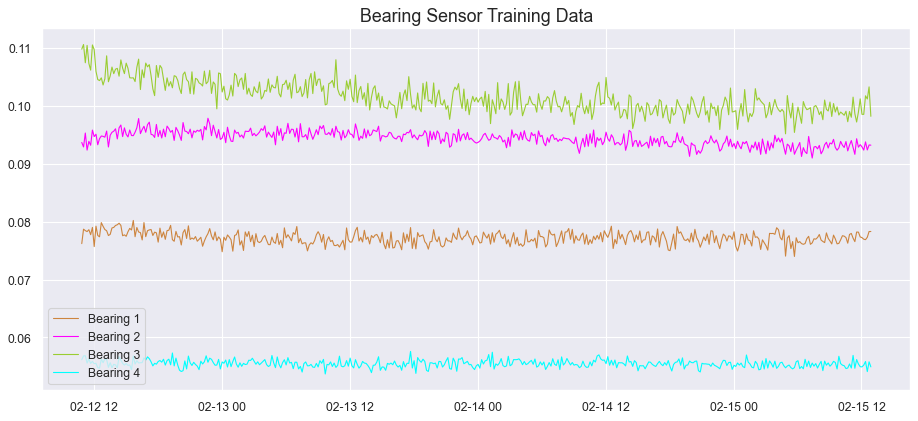

In [9]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='peru', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='magenta', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='yellowgreen', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='cyan', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [10]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

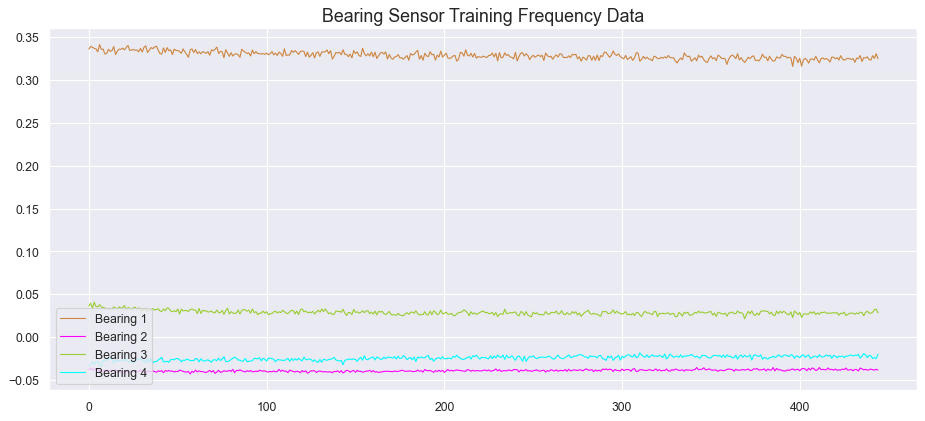

In [11]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='peru', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='magenta', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='yellowgreen', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='cyan', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

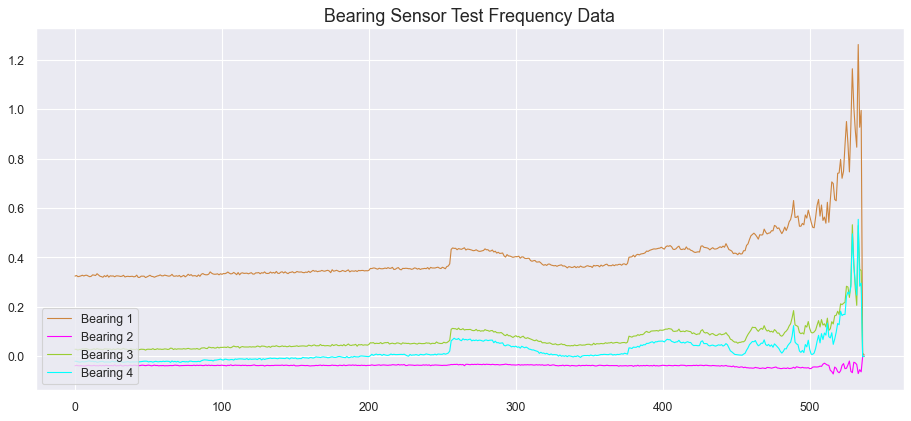

In [12]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='peru', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='magenta', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='yellowgreen', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='cyan', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [14]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [15]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [16]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)             

In [17]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 2s 47ms/step - loss: 0.4481 - val_loss: 0.3234
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.3837 - val_loss: 0.2484
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 0.2919 - val_loss: 0.1607
Epoch 4/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1624 - val_loss: 0.1638
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1135 - val_loss: 0.1351
Epoch 6/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1050 - val_loss: 0.1185
Epoch 7/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1016 - val_loss: 0.1110
Epoch 8/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0998 - val_loss: 0.1106
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0992 - val_loss: 0.1106
Epoch 10/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0992 - val_loss: 0.1076
Epoch 11

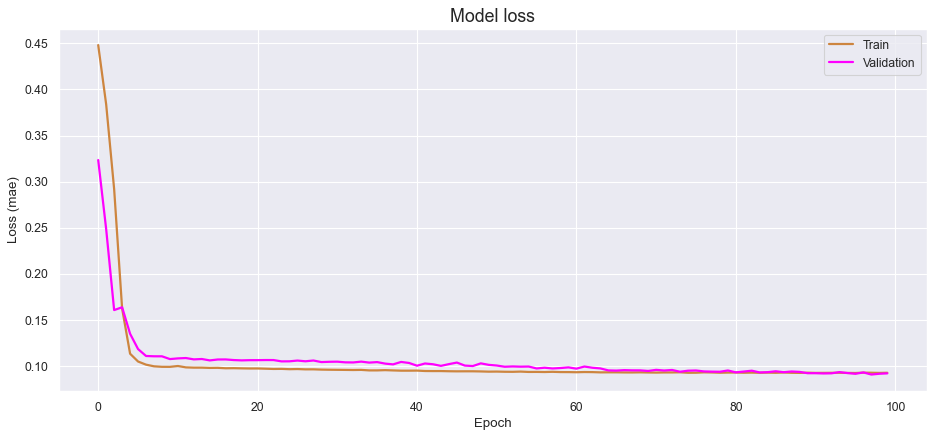

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'peru', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'magenta', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

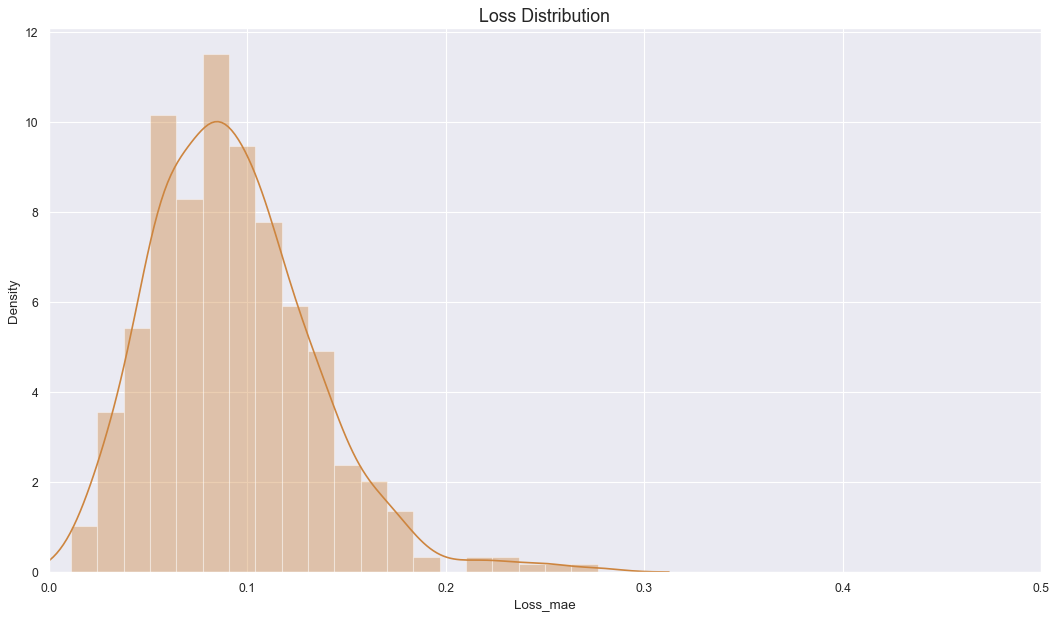

In [19]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'peru');
plt.xlim([0.0,.5])

In [20]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.112378,0.275,False
2004-02-15 13:02:39,0.195153,0.275,False
2004-02-15 13:12:39,0.069562,0.275,False
2004-02-15 13:22:39,0.049319,0.275,False
2004-02-15 13:32:39,0.033779,0.275,False


In [21]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

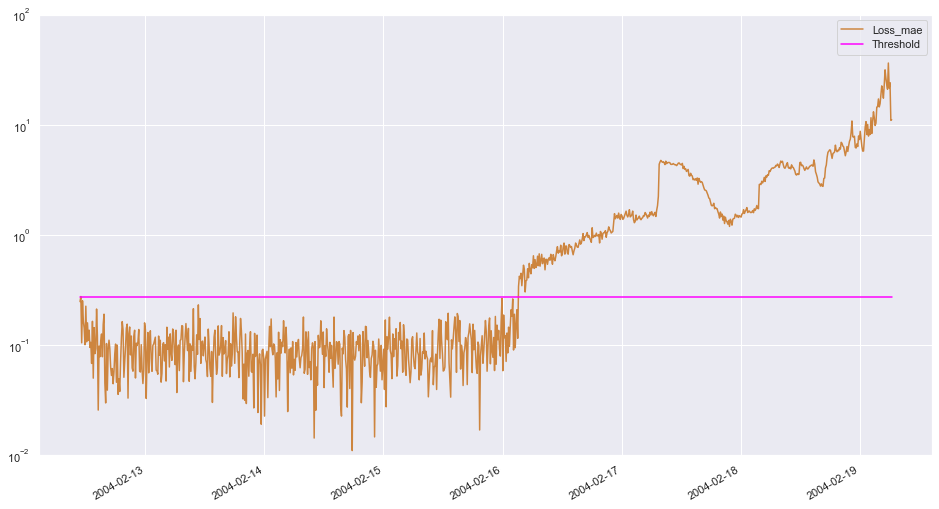

In [22]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['peru','magenta'])


In [23]:
model.save("anomalydetection.h5")
